In [1]:
import os
from params import Params as pm
from tqdm import tqdm
import numpy as np
import time
import re
from string import punctuation as p
import tensorflow as tf
tf_ver = tf.__version__

p += '！？｡＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃《》「」『』【】〔〕〖〗〘〙〚〛' \
	 '〜〝〞〟〰�〾〿–—‘・’‛“”„‟…‧﹏.□'

tf.enable_eager_execution()

In [2]:
tf_ver

'1.12.0'

---

# Data Preprocessing

In [ ]:
def cleaner(text, stopwords=None, specialwords=None, remove_alphas=False, remove_numbers=False,
			remove_urls=False, remove_punctuation=False, remove_email=False, remove_ip_address=False,
			keep_chinese_only=False):
	alphas = re.compile(r"[A-Za-z]+", re.IGNORECASE)
	numbers = re.compile(r"\d+", re.IGNORECASE)
	email = re.compile(r"[A-Za-z0-9\u4e00-\u9fa5]+@[a-zA-Z0-9_-]+(\.[a-zA-Z0-9_-]+)+$", re.IGNORECASE)
	url_1 = re.compile(r"((https?|ftp|file):\/\/)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", re.IGNORECASE)
	url_2 = re.compile(r"[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", re.IGNORECASE)
	ips = re.compile(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}(:)?[0-9]{1,8}", re.IGNORECASE)

	chinese_pattern = re.compile(u'[\u4e00-\u9fa5]+')
	stop_p = p + "！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰�〾〿–—‘・’‛“”„‟…‧﹏."
	num_maps = {'{}'.format(i): '{}'.format(j) for i, j in zip(range(10), ['零', '壹', '贰', '叁', '肆', '伍', '陆', '柒', '捌', '玖'])}

	text = re.sub(r'\u0020+', ' ', text)
	text = re.sub(r'\xa0+', ' ', text)

	if keep_chinese_only:
		text = " ".join(chinese_pattern.findall(text))
	else:
		text = re.sub(r"what's", "what is", text)
		text = re.sub(r"\'s", " is", text)
		text = re.sub(r"\'ve", " have", text)
		text = re.sub(r"can't", "cannot", text)
		text = re.sub(r"n't", " not", text)
		text = re.sub(r"i'm", "i am", text)
		text = re.sub(r"i’m", "i am", text)
		text = re.sub(r"\'re", " are", text)
		text = re.sub(r"\'d", " would", text)
		text = re.sub(r"\'ll", " will", text)

		text = text.lower()
		if specialwords is not None:
			for word in specialwords:
				if word in text:
					if numbers.match(word):
						new_word = ""
						for char in word:
							tmp = num_maps.get(char)
							if tmp is not None:
								new_word += tmp
							else:
								new_word += char
						text = text.replace(word, new_word)
					else:
						text = text.replace(word, word.capitalize())

	if remove_urls:
		text = url_1.sub(' ', text)
		text = url_2.sub(' ', text)
	if remove_ip_address:
		text = ips.sub(' ', text)
	if remove_email:
		text = email.sub(' ', text)
	if remove_alphas:
		text = alphas.sub(' ', text)
	if remove_numbers:
		text = numbers.sub(' ', text)

	if remove_punctuation:
		for punc in stop_p:
			if punc in text:
				text = text.replace(punc, ' ')

	if stopwords is not None:
		text = "".join([char for char in text if char not in stopwords])

	text = re.sub(r" +", " ", text)

	return text

In [ ]:
def shuffle_data(corpus):
	if isinstance(corpus, list):
		corpus = np.array(corpus)
	indices = np.arange(len(corpus))
	shuffled_indices = np.random.permutation(indices)
	return corpus[shuffled_indices]

In [ ]:
if not os.path.exists("data/processed/{}".format(pm.project_name)):
    os.makedirs("data/processed/{}".format(pm.project_name))
    
######
## DUMP FROM ORIGINAL DATASET WITH 'SRC{\t}TGT\n' FORMATS
######

# sources, targets = [], []
# with open(pm.origin_source, 'r', encoding='utf-8') as f:
#     for line in tqdm(f):
#         line = line.strip('\n')
#         try:
#             src, tgt = line.split('\t')
#             src = cleaner(src,
#                           remove_urls=True,
#                           remove_punctuation=True,
#                           remove_email=True,
#                           remove_ip_address=True)
#             tgt = cleaner(tgt,
#                           remove_urls=True,
#                           remove_punctuation=True,
#                           remove_email=True,
#                           remove_ip_address=True)
#             if src == ' ' or src is None or tgt == ' ' or tgt is None:
#                 continue
                
#             if len(list(src)) > 0 and len(list(tgt)) > 0:
#                 sources.append(" ".join([i for i in list(src) if i != ' ']))
#                 targets.append(" ".join([i for i in list(tgt) if i != ' ']))
#         except Exception as e:
#             print(e)
#             continue
            
# shuffled_src = shuffle_data(sources)
# shuffled_tgt = shuffle_data(targets)

# src_train, src_val = shuffled_src[:int(len(shuffled_src) * 0.7)], shuffled_src[int(len(shuffled_src) * 0.7):]
# tgt_train, tgt_val = shuffled_tgt[:int(len(shuffled_tgt) * 0.7)], shuffled_tgt[int(len(shuffled_tgt) * 0.7):]

# def write_down(path, data):
#     with open(path, 'w', encoding='utf-8') as f:
#         f.write("\n".join(data))

# paths, datas = [pm.src_train, pm.tgt_train, pm.src_test, pm.tgt_test], [src_train, tgt_train, src_val, tgt_val]
# for path, data in zip(paths, datas):
#     write_down(path, data)

In [3]:
from utils import build_vocab, load_vocab, dump2record, build_dataset, LRSchedule, create_masks, en2idx, idx2en, de2idx, idx2de
# from lr_schedule_v1 import LRSchedule

In [ ]:
dump2record(pm.train_record, src_train, tgt_train)
dump2record(pm.test_record, src_val, tgt_val)

In [4]:
train_dataset = build_dataset(mode='file', filename=pm.train_record, is_training=True)
val_dataset = build_dataset(mode='file', filename=pm.test_record, is_training=False)

---

# Sub Module overview

In [5]:
####### overview #######
inp, tar = next(iter(train_dataset))
inp.numpy().shape, tar.numpy().shape

((64, 12), (64, 12))

In [39]:
from modules import positional_encoding, scaled_dot_product_attention, multihead_attention, pointwise_feedforward, \
EncoderBlock, DecoderBlock, Encoder, Decoder, Transformer

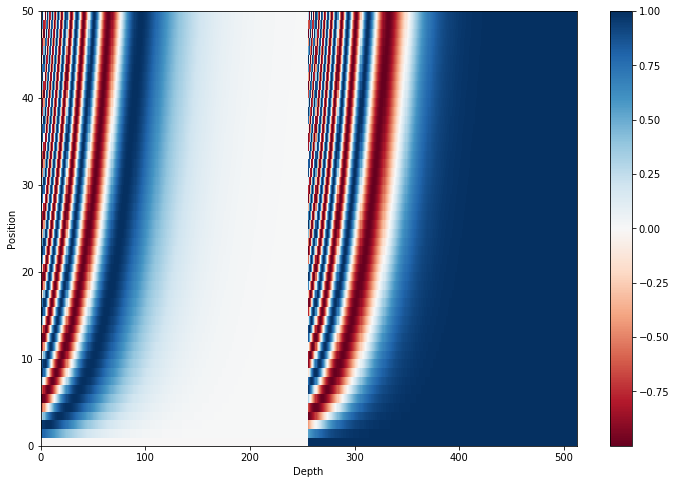

In [7]:
pos_encoding = positional_encoding(50, pm.d_model, True)

In [8]:
enc_mask, combined_mask, dec_mask = create_masks(inp, tar)
enc_mask.numpy().shape, combined_mask.numpy().shape, dec_mask.numpy().shape

((64, 1, 1, 12), (64, 1, 12, 12), (64, 1, 1, 12))

In [9]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [10]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [11]:
temp_mha = multihead_attention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 50, 512))
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.numpy().shape, attn.numpy().shape

((1, 50, 512), (1, 8, 50, 50))

In [12]:
sample_ffn = pointwise_feedforward(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).numpy().shape

(64, 50, 512)

In [13]:
sample_encoder_layer = EncoderBlock(512, 8, 2048)
sample_encoder_layer_output, attn = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)
sample_encoder_layer_output.numpy().shape, attn.numpy().shape

((64, 43, 512), (64, 8, 43, 43))

In [14]:
sample_decoder_layer = DecoderBlock(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.numpy().shape

(64, 50, 512)

In [15]:
sample_encoder = Encoder(num_blocks=2, d_model=512, num_heads=8, dff=2048, plot_pos_embedding=False, input_vocab_size=8500)
sample_encoder_output, _ = sample_encoder(tf.random.uniform((64, 62)), training=False, padding_mask=None, attn_dict={})
sample_encoder_output.numpy().shape

(64, 62, 512)

In [16]:
sample_decoder = Decoder(num_blocks=2, d_model=512, num_heads=8, dff=2048, plot_pos_embedding=False, target_vocab_size=8000)
output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None,
                              attn_dict={})
output.numpy().shape, attn['decoder_layer2_block'].numpy().shape

((64, 26, 512), (64, 8, 26, 26))

In [17]:
sample_transformer = Transformer(num_blocks=2, d_model=512, num_heads=8, dff=2048, input_vocab_size=8500, target_vocab_size=8000, plot_pos_embedding=False, rate=pm.dropout_rate)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, 
                               temp_target, 
                               training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.numpy().shape

(64, 26, 8000)

In [27]:
learning_rate = LRSchedule(tf.range(40000, dtype=tf.float32), pm.d_model, pm.learning_rate_warmup_steps)

Text(0.5, 0, 'Train Step')

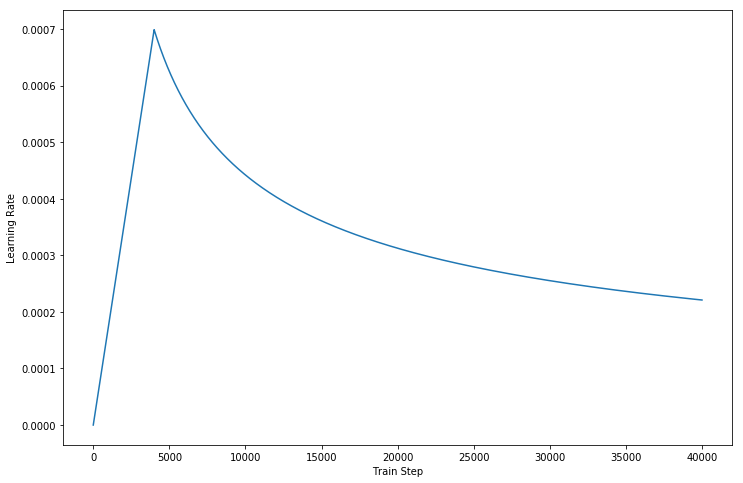

In [30]:
####### overview #######
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(learning_rate().numpy())
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Training

In [35]:
from bleu import bleu_metrics

In [36]:
input_vocab_size = len(en2idx)
target_vocab_size = len(de2idx)

learning_rate = LRSchedule(pm.d_model, pm.learning_rate_warmup_steps)
optimizer = tf.train.AdamOptimizer(learning_rate, beta1=pm.beta_1, beta2=pm.beta_2, epsilon=pm.epsilon)
# optimizer = tf.train.AdamOptimizer()

In [37]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = tf.keras.backend.sparse_categorical_crossentropy(real, pred, from_logits=True)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [40]:
model = Transformer(pm.num_block,
                    pm.d_model,
                    pm.num_heads,
                    pm.dff,
                    input_vocab_size,
                    target_vocab_size,
                    pm.plot_pos_embedding,
                    pm.dropout_rate)

In [41]:
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckpt_dir = os.path.join(pm.ckpt_path, 'ckpt')

if tf.train.latest_checkpoint(ckpt_dir):
    model.load_weights(tf.train.latest_checkpoint(ckpt_dir))
    print('Latest model restored!')

In [42]:
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = model(inp,
                               tar_inp,
                               True,
                               enc_padding_mask,
                               look_ahead_mask,
                               dec_padding_mask)

        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return tf.stack(tar_real), tf.stack(tf.cast(tf.argmax(predictions, axis=-1), tf.int32)), loss

In [ ]:
for epoch in range(pm.num_epochs):
    start = time.time()
    
    hidden = model.reset_states()
    train_loss, bleu_score, available = 0., 0., 0
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
        tar_reals, predictions, loss = train_step(inp, tar)
        
        preds = [[idx2de.get(idx, 1) for idx in prediction if idx not in [0, 1, 2 ,3]] for prediction in predictions.numpy()]
        refs = [[[idx2de.get(idx, 1) for idx in tar_real if idx not in [0, 1, 2, 3]]] for tar_real in tar_reals.numpy()]
        bleu = bleu_metrics(refs, preds, True, 3)
        
        if bleu != 0.:
            bleu_score += bleu
            train_loss += loss
            available += 1
        
        if batch % pm.batch_show_every == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, loss))
            
    if (epoch + 1) % pm.epoch_show_every == 0:
        model.save_weights(ckpt_dir)
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_dir))
        print('Epoch {} Loss {:.4f} Bleu_score {:.4f}'.format(epoch + 1, train_loss / available, bleu_score / available))
        print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

# Evaluate & Test

In [ ]:
def evaluate(inp):
    encoder_input = tf.expand_dims(inp, axis=0)
    
    decoder_input = [2]
    output = tf.expand_dims(decoder_input, axis=0)
    
    for i in range(pm.maxlen):
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(encoder_input, output)
        
        predictions, attn_weights = transformer(encoder_input,
                                                output,
                                                False,
                                                enc_padding_mask,
                                                look_ahead_mask,
                                                dec_padding_mask,
                                                False,
                                                pm.dropout_rate)
        
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        if tf.equal(predicted_id, 3):
            return tf.squeeze(output, axis=0), att_weights
        
        # self regression
        output = tf.concat([output, predicted_id], axis=-1)
        
    return tf.squeeze(output, axis=0), attn_weights

In [ ]:
eval_log = os.path.join(pm.eval_log_path, '{}.tsv'.format(pm.project_name))
eval_file = open(eval_log, 'w', encoding='utf-8')

start = time.time()

for (batch, (inp, tar)) in enumerate(val_dataset):
    tar_real = [idx2de.get(word, 1) for word in tar.numpy() if word < len(idx2de) and word not in [0, 1, 2, 3]]
    prediction, _ = evaluate(inp)

    source = [idx2en.get(word, 1) for word in inp.numpy() if word < len(idx2en) and word not in [0, 1, 2, 3]]
    preds = [[idx2de.get(idx, 1) for idx in prediction.numpy() if idx not in [0, 1, 2 ,3]]]
    refs = [[tar_real]]
    bleu = bleu_metrics(refs, preds, False, 3, True)

    eval_file.write('-Source : {}\n-Target : {}\n-Pred : {}\n-BLEU Score: {:.4f}\n\n'.format(
        "".join(source), "".join(tar_real), "".join(preds[0]), bleu))

In [ ]:
def test(inp):
    start_token = [2]
    end_token = [3]
    
    inp = start_token + inp + end_token
    encoder_input = tf.expand_dims(inp, axis=0)
    
    decoder_input = [2]
    output = tf.expand_dims(decoder_input, axis=0)
    
    for i in range(pm.maxlen):
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(encoder_input, output)
        
        predictions, attn_weights = transformer(encoder_input,
                                                output,
                                                False,
                                                enc_padding_mask,
                                                look_ahead_mask,
                                                dec_padding_mask,
                                                False,
                                                pm.dropout_rate)
        
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        if tf.equal(predicted_id, 3):
            return tf.squeeze(output, axis=0), att_weights
        
        # self regression
        output = tf.concat([output, predicted_id], axis=-1)
        
    return tf.squeeze(output, axis=0), attn_weights

In [ ]:
def translate_interface(sentence, plot=''):
    result, attention_weights = evaluate(sentence)

    original_sentence = "".join([idx2en.get(word, 1) for word in sentence.numpy()])
    predicted_sentence = "".join([idx2de.get(word, 1) for word in result.numpy() if word < len(idx2de) and word not in [0, 1, 2, 3]])

    print('Input: {}'.format(original_sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [ ]:
inp, tar = next(iter(val_dataset))
tar = "".join([idx2de.get(word, 1) for word in tar.numpy()])

translate_interface(inp, plot='decoder_layer6_block')
print ("Real translation: {}".format(tar))